# Ui-Wing Cheah
## EN 625.633 Module 13 Assignment

In [16]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
%matplotlib inline
sns.set_style('darkgrid')

In [61]:
def Kalman_Filtering_Example(n):
    # Establishing Sigma Values
    sigma_V = 0.2
    sigma_W = 0.1

    # Prespecifying vectors
    X = np.zeros(n)
    Y = np.zeros(n)
    X_hat_pred = np.zeros(n)
    X_hat_filt = np.zeros(n)
    Omega = np.zeros(n)
    Delta = np.zeros(n)
    Theta = np.zeros(n)

    Omega_filt = np.zeros(n)
    Delta_filt = np.zeros(n)
    Theta_filt = np.zeros(n)

    Xdist = sp.norm(loc=0,scale=sigma_V)
    Ydist = sp.norm(loc=0,scale=sigma_W)
    # Initializing - python convention
    X[0]= Xdist.rvs(size=1)
    Y[0] = X[0]+Ydist.rvs(size=1)
    Omega[0] = 0.04
    Delta[0] = Omega[0]+pow(sigma_W,2)
    Theta[0] = Omega[0]

    Omega_filt[0] = 0.04
    Delta_filt[0] = Delta[0]
    Theta_filt[0] = Theta[0]

    # iterating through
    for j in range(1,n):
        # doing prediction
        X_hat_pred[j] = X_hat_pred[j-1]+(Theta[j-1]/Delta[j-1])*(Y[j-1] - X_hat_pred[j-1])
        Omega[j] = Omega[j-1]+sigma_V**2-Theta[j-1]**2/Delta[j-1]
        Delta[j] = Omega[j]+sigma_V**2
        Theta[j] = Omega[j]

        # simulating next value of X and Y
        X[j] = X[j-1]+Xdist.rvs(size=1)
        Y[j] = X[j]+Ydist.rvs(size=1)

        # filtering
        X_hat_filt[j] = X_hat_pred[j] + (Omega[j]/Delta[j])*(Y[j] - X_hat_pred[j])
        Omega_filt[j] = Omega[j]-pow(Omega[j],2)/Delta[j]

        Delta_filt[j] = Omega_filt[j]+sigma_V**2
        Theta_filt[j] = Omega_filt[j]
    
    # plotting the data
    results = pd.DataFrame({'X':pd.Series(X),'X_pred':pd.Series(X_hat_pred), 
                            'X_filt': pd.Series(X_hat_filt),'Omega':pd.Series(Omega),'Delta':pd.Series(Delta),
                            'Theta':pd.Series(Theta), 'Omega_filt':pd.Series(Omega_filt), 'Delta_filt':pd.Series(Delta_filt),
                            'Theta_filt':pd.Series(Theta_filt), 'Y':pd.Series(Y)})

    ax_ = results.loc[:,['X','X_pred','X_filt']].plot()
    return results

def Kalman_Smooth(xinit,omegainit,delta_filt,theta_filt,pred_error):
    # initialize smoothers
    x_smooth = np.zeros(len(delta_filt)+1)
    omega = np.zeros(len(delta_filt)+1)
    x_smooth[0] = xinit
    omega[0] = omegainit
    j=0
    for delta_theta_eps in zip(delta_filt,theta_filt,pred_error):
        j+=1
        d_ = delta_theta_eps[0]
        t_ = delta_theta_eps[1]
        e_ = delta_theta_eps[2]
        x_smooth[j] = x_smooth[j-1]+omega[j-1]*e_/d_
        omega[j] = omega[j-1]*(1-t_/d_)
    return x_smooth


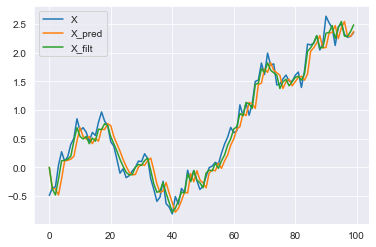

In [47]:
example1 = Kalman_Filtering_Example(100)

### Problem 1

In [62]:
# run Kalman Smoothing
init_sample = example1.loc[49]
x0 = init_sample['X_filt']
omega0 = init_sample['Omega_filt']
data = example1.iloc[50:]
pred_error = data['Y']-data['X_pred']
test = Kalman_Smooth(x0,omega0,data['Delta_filt'].values,data['Theta_filt'].values,pred_error)

In [155]:
print(test)
print('Smoothed Estimate: {0:.4f}'.format(test[-1]))

[-0.2692771  -0.32299028 -0.22507735 -0.21256394 -0.21463438 -0.20274974
 -0.20763412 -0.20321218 -0.2010225  -0.19878595 -0.19789347 -0.19702505
 -0.19689515 -0.19645572 -0.19649993 -0.19633114 -0.19634288 -0.19636466
 -0.1962926  -0.19629014 -0.19627374 -0.19627622 -0.19627201 -0.19627403
 -0.19627445 -0.19627471 -0.19627556 -0.19627529 -0.19627523 -0.19627533
 -0.19627529 -0.19627527 -0.19627526 -0.19627527 -0.19627526 -0.19627524
 -0.19627524 -0.19627524 -0.19627524 -0.19627524 -0.19627524 -0.19627524
 -0.19627524 -0.19627524 -0.19627524 -0.19627524 -0.19627524 -0.19627524
 -0.19627524 -0.19627524 -0.19627524]
Smoothed Estimate: -0.1963


In [164]:
print('Predicted Estimate: {0:.4f}'.format(example1.loc[49]['X_pred']))
print('Filtered Estimate: {0:.4f}'.format(example1.loc[49]['X_filt']))
print('Smoothed Estimate: {0:.4f}'.format(test[-1]))

Predicted Estimate: -0.2202
Filtered Estimate: -0.2693
Smoothed Estimate: -0.1963


### Problem 3

In [67]:
underwater = pd.read_csv('c:/users/nowuc/Code/data/underwater.csv')

In [140]:
def underwater_prob(*args,**kwargs):
    inv = np.linalg.inv
    dot = np.dot
    y_data = pd.read_csv('c:/users/nowuc/Code/data/underwater.csv')
    n = len(y_data)
    # defining F matrix
    F = np.identity(6)
    F[0,3] = 1
    F[1,4] = 1
    F[2,5] = 1
    # defining G matrix
    G = np.identity(6)

    # getting multivariate noise
    sigma_V = 0.02
    sigma_W = 0.01
    cov_V = (sigma_V**2)*np.identity(6)
    cov_W = (sigma_W**2)*np.identity(6)

    Vdist = sp.multivariate_normal(mean=np.zeros(6,),cov=cov_V)
    Wdist = sp.multivariate_normal(mean=np.zeros(6,),cov=cov_W)

    # initializing X vectors
    X_hat_pred = np.zeros(shape=y_data.shape)
    X_hat_filt = np.zeros(shape=y_data.shape)

    Omega_pred = np.zeros(shape=(n,6,6))
    Omega_filt = np.zeros(shape=(len(y_data),6,6))

    Delta_pred = np.zeros(shape=(n,6,6))
    Theta_pred = np.zeros(shape=(n,6,6))
    Delta_filt = np.zeros(shape=(n,6,6))
    Theta_filt = np.zeros(shape=(n,6,6))

    # initializing         
    Y = y_data
    X_hat_pred[0] = Vdist.rvs(1)
    Omega_pred[0] = np.dot(F,np.dot(cov_V,F.T))
    Delta_pred[0] = np.dot(G,np.dot(Omega_pred[0],G.T))+cov_W
    Theta_pred[0] = np.dot(F,np.dot(Omega_pred[0],G.T))

    for j in range(1,n):
        ehat = Y.iloc[j-1].values - np.dot(G,X_hat_pred[j-1])
        # getting predictions
        X_hat_pred[j]= dot(F,X_hat_pred[j-1])+ dot(Omega_pred[j-1],dot(inv(Delta_pred[j-1]),ehat))
        Omega_pred[j] = dot(F,dot(Omega_pred[j-1],F.T))-dot(Omega_pred[j-1],dot(inv(Delta_pred[j-1]),Omega_pred[j-1].T
        ))+cov_V
        Delta_pred[j] = dot(G,dot(Omega_pred[j],G.T))+sigma_W
        Theta_pred[j] = dot(F,dot(Omega_pred[j],G.T))

        # filtering estimate
        ehat_pred = Y.iloc[j].values - dot(G,X_hat_pred[j])
        X_hat_filt[j] = X_hat_pred[j] + dot(Omega_pred[j],dot(G,dot(inv(Delta_pred[j]),ehat_pred)))

        # omega filt
        Omega_filt[j] = Omega_pred[j] - dot(Omega_pred[j],dot(G.T,dot(inv(Delta_pred[j]),dot(G,Omega_pred[j].T))))
    
    X_pred = pd.DataFrame(data=X_hat_pred,columns=Y.columns)
    X_filt = pd.DataFrame(data=X_hat_filt,columns=Y.columns)
    
    results = pd.concat({'Y':Y,'X_pred':X_pred,'X_filt':X_filt},sort=True)
    
    return results.swaplevel(0,1).sort_index(level=0)


In [149]:
p3_results =underwater_prob()

In [165]:
print(p3_results.loc[51:52,].round(decimals=2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
   &   &       u &  u\_dot &     y &  y\_dot &     z &  z\_dot \\
\midrule
51 & X\_filt &  106.65 &   2.41 & -6.94 &  -0.58 & -4.59 &  -0.03 \\
   & X\_pred &  106.76 &   2.69 & -6.92 &  -0.53 & -4.34 &  -0.27 \\
   & Y &  106.43 &   2.19 & -7.17 &  -0.81 & -4.82 &  -0.26 \\
52 & X\_filt &  108.92 &   2.51 & -7.40 &  -0.79 & -4.81 &  -0.03 \\
   & X\_pred &  109.34 &   2.41 & -7.47 &  -0.58 & -4.87 &  -0.03 \\
   & Y &  108.73 &   2.31 & -7.60 &  -0.99 & -5.01 &  -0.22 \\
\bottomrule
\end{tabular}



In [152]:
p3_results.loc[51:52,]

u     u_dot         y     y_dot         z     z_dot
51 X_filt  106.654293  2.411238 -6.941892 -0.584930 -4.593503 -0.034196
   X_pred  106.758422  2.685437 -6.921297 -0.532491 -4.344569 -0.271844
   Y       106.430495  2.187440 -7.165690 -0.808728 -4.817301 -0.257994
52 X_filt  108.922154  2.505537 -7.397949 -0.791931 -4.812966 -0.027668
   X_pred  109.339730  2.411238 -7.474383 -0.584930 -4.865347 -0.034196
   Y       108.725086  2.308469 -7.595017 -0.988999 -5.010034 -0.224736

In [154]:
underwater.loc[51:52]

,u,y,z,u_dot,y_dot,z_dot
51,106.430495,-7.165690,-4.817301,2.187440,-0.808728,-0.257994
52,108.725086,-7.595017,-5.010034,2.308469,-0.988999,-0.224736
